In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import json
from time import time
import pickle
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import cv2

Using TensorFlow backend.


### Reading all the captions

In [2]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

captions  = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
print(len(captions))

40460


### Dictionary that maps image to all the captions it has

In [3]:
image_description = {}
for text in captions:
    part1,part2 = text.split('\t')
    img_name = part1.split('.')[0]
    
    if image_description.get(img_name) is None:
        image_description[img_name] = []
    
    image_description[img_name].append(part2)


### Data Cleaning by lower casing & removing Special Characters and 1 Letter things

In [4]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

# Clean all Captions
for key,caption_list in image_description.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
        
# Write the cleaned_data to text file
with open("Cleaned_description.txt","w") as f:
    f.write(str(image_description))

### Building a Vocabulary

In [5]:
import collections

descriptions = None
with open("Cleaned_description.txt",'r') as f:
    descriptions= f.read()    

# Changing the description from type(str) to type(dict)
json_string = descriptions.replace("'","\"")
descriptions = json.loads(json_string)

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

# Filter Words from the Vocab according to certain threshold frequncy
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for desc in descriptions[key] for i in desc.split()]

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

### Prepare the Train and Test Data

In [6]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for phrase in image_description[img_id]:
        phrase_to_append = "startseq "  + phrase + " endseq" # Adding a start token and end token as stratseq and endseq
        train_descriptions[img_id].append(phrase_to_append)


### Data Preprocessing

#### Image Preprocessing Using Resnet50 via Transfer learning

In [7]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [8]:
IMG_PATH = "Data/Images/"

model_new = Model(model.input,model.layers[-2].output)

def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img) # Normalisation
    return img

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector


start = time()
encoding_train = {}

for idx,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if idx%100==0:
        print("Encoding in Progress Time step %d "%idx)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 


KeyboardInterrupt: 

In [9]:
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)
    
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)
    

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 134.9366762638092


#### Caption Preprocessing

In [11]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1

# Calculating the maximum length of caption among every caption of every image
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [13]:
with open("./saved/word_to_idx.pkl", 'wb') as w2i:
    pickle.dump(word_to_idx,w2i)
    
with open("./saved/idx_to_word.pkl", 'wb') as i2w:
    pickle.dump(idx_to_word,i2w)

### Data Preparation (Generator)

In [30]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

### Word Embedding

In [25]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

f.close()

def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

### Model Architecture

In [26]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       92400       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [27]:
# Setting the Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy',optimizer="adam")

In [28]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [31]:
for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

Epoch 1/1
2000/2000 [==============================] - 495s 248ms/step - loss: 4.2935
Epoch 1/1
2000/2000 [==============================] - 429s 215ms/step - loss: 3.5740
Epoch 1/1
2000/2000 [==============================] - 421s 211ms/step - loss: 3.3161
Epoch 1/1
2000/2000 [==============================] - 429s 214ms/step - loss: 3.1605
Epoch 1/1
2000/2000 [==============================] - 422s 211ms/step - loss: 3.0476
Epoch 1/1
2000/2000 [==============================] - 418s 209ms/step - loss: 2.9633
Epoch 1/1
2000/2000 [==============================] - 420s 210ms/step - loss: 2.8946
Epoch 1/1
2000/2000 [==============================] - 418s 209ms/step - loss: 2.8438
Epoch 1/1
2000/2000 [==============================] - 419s 209ms/step - loss: 2.7927
Epoch 1/1
2000/2000 [==============================] - 433s 217ms/step - loss: 2.7530
Epoch 1/1
2000/2000 [==============================] - 424s 212ms/step - loss: 2.7186
Epoch 1/1
2000/2000 [==============================] -

In [17]:
# model = load_model('./model_weights/model_9.h5')

### Predictions

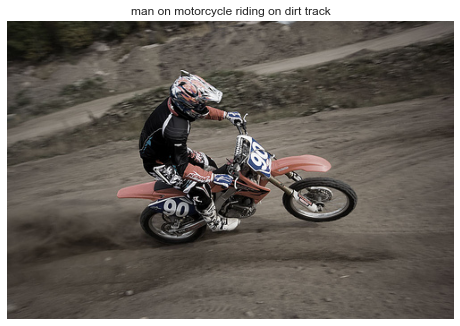

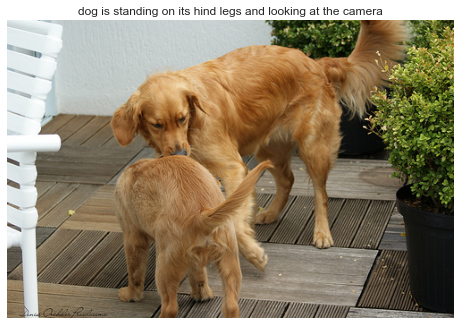

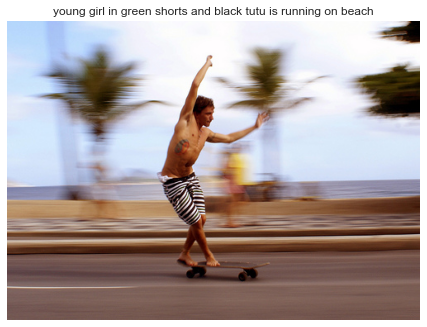

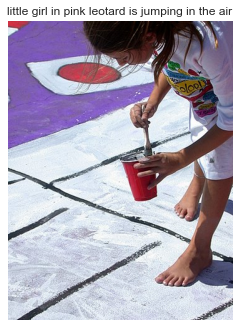

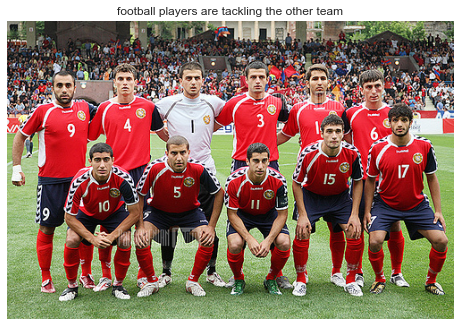

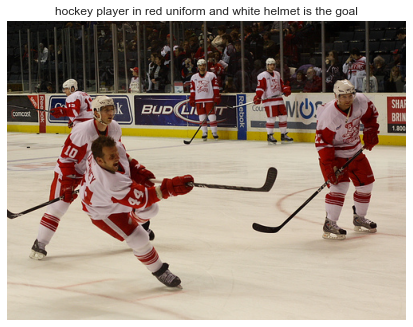

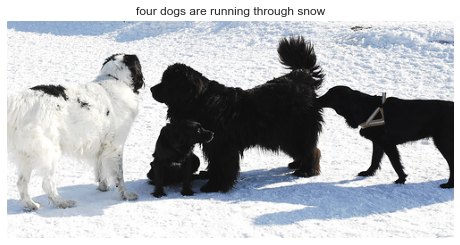

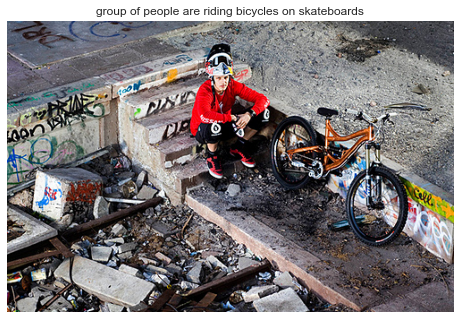

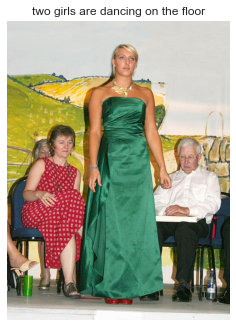

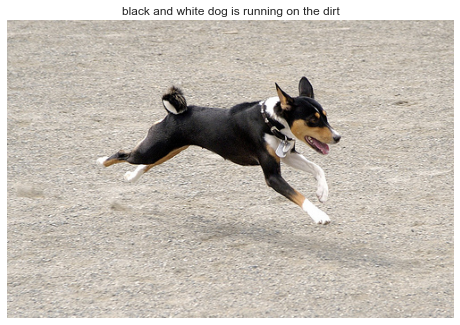

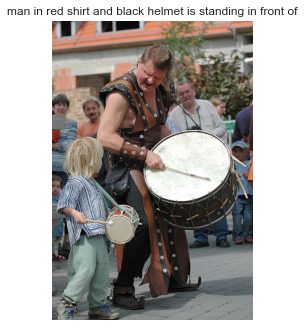

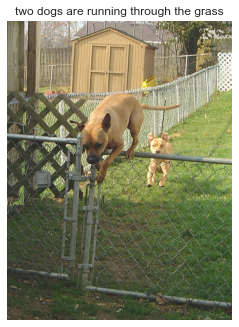

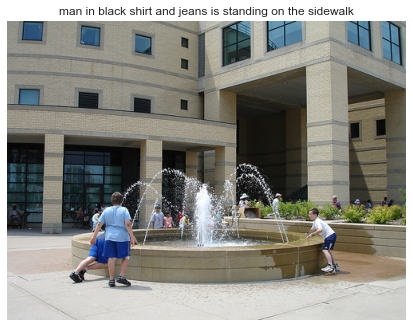

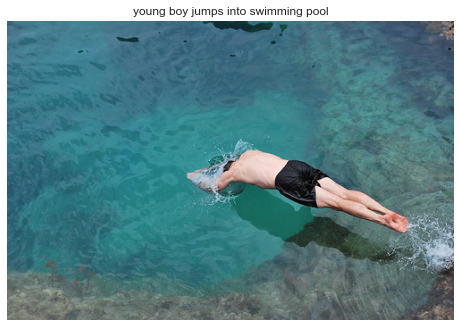

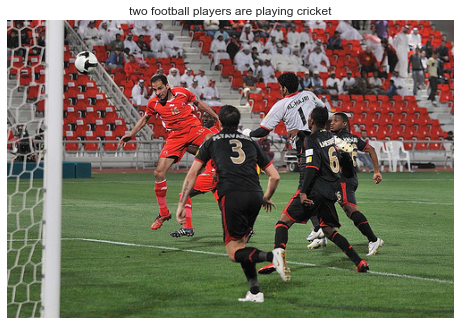

In [32]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    